In [1]:
import os, sys
import h5py
import numpy as np

import matplotlib.pyplot as plt

import logging


save_dir_name = 'climaX_longForecast'
#save_dir_name = 'climaX_ObsNoise_randLocs'

save_dir = '/eagle/MDClimSim/mjp5595/data/{}/'.format(save_dir_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

means = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_mean.npz')
stds = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_std.npz')

background_file_np = '/eagle/MDClimSim/mjp5595/ml4dvar/background_starter.npy' # This is just to initialize the model background

from vars_climaX import vars_climaX
vars_climax = vars_climaX().vars_climax

background_f = np.load(background_file_np, 'r')
print('background_f.shape :',background_f.shape)

background_f.shape : (1, 82, 128, 256)


In [2]:
def unstandardizeForecast(forecast, means=None, stds=None, climax_vars=None):
    if means is None:
        raise ValueError('Means is not defined and has not been input.')
    if stds is None:
        raise ValueError('Stds is not defined and has not been input.')
    if means is not None:
        means_array = np.zeros(len(climax_vars))
        for i, var in enumerate(climax_vars):
            val = means[var][0]
            means_array[i] = val
        means = means_array
    if stds is not None:
        stds_array = np.zeros(len(climax_vars))
        for i, var in enumerate(climax_vars):
            stds_array[i] = stds[var][0]
        stds = stds_array
    #forecasts_unstandardized = forecasts * stds.reshape(1, 1, -1, 1, 1) + \
    #                           means.reshape(1, 1, -1, 1, 1)
    # forecasts -> (forecast_steps,vars,lat,lon)
    forecasts_unstandardized = np.zeros_like(forecast)
    for i in range(len(means)):
        forecasts_unstandardized[i,:,:] = forecast[i,:,:] * stds[i]
        forecasts_unstandardized[i,:,:] = forecasts_unstandardized[i,:,:] + means[i]
    return forecasts_unstandardized

inc_max : 0.7078032493592445
total_var_increment.shape : (1000, 4, 82)


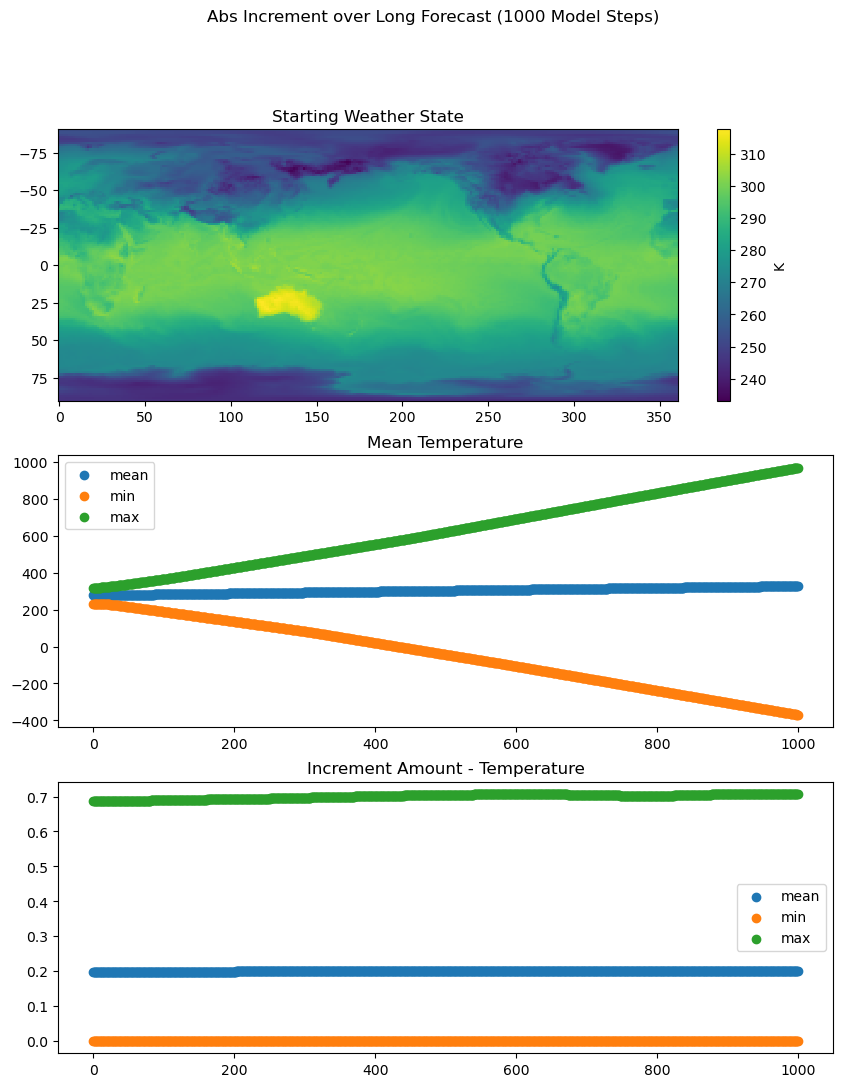

In [16]:
from matplotlib import colors
from matplotlib import cm

means = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_mean.npz')
stds = np.load('/eagle/MDClimSim/tungnd/data/wb2/1.40625deg_from_full_res_1_step_6hr_h5df/normalize_std.npz')

total_var_increment = []
mean_temperature = []
background_unstandardized = unstandardizeForecast(background_f[0],means=means,stds=stds,climax_vars=vars_climax)
prev_forecast = background_unstandardized
hf = h5py.File(os.path.join(save_dir, 'longForecast.h5'),'r')
inc_max = 0
for step in range(len(hf.keys())):
    forecast = hf[str(step)]
    #print('forecast mean,min,max :',np.mean(forecast[0]),np.min(forecast[0]),np.max(forecast[0]))
    forecast = unstandardizeForecast(forecast,means=means,stds=stds,climax_vars=vars_climax)
    #print('unstandardized_forecast mean,min,max :',np.mean(forecast[0]),np.min(forecast[0]),np.max(forecast[0]))

    mean_temperature.append([np.sum(forecast[0]),np.mean(forecast[0]),np.min(forecast[0]),np.max(forecast[0])])
    increment = np.abs(forecast - prev_forecast)
    #print('increment mean,min,max :',np.mean(increment[0]),np.min(increment[0]),np.max(increment[0]))
    total_var_increment.append([np.sum(increment,axis=(1,2)),np.mean(increment,axis=(1,2)),np.min(increment,axis=(1,2)),np.max(increment,axis=(1,2))])
    prev_forecast = forecast
    inc_max = max(inc_max,np.max(increment[0]))


mean_temperature = np.array(mean_temperature)
total_var_increment = np.array(total_var_increment)
print('inc_max :',inc_max)
print('total_var_increment.shape :',total_var_increment.shape)
# Plotting the results
lon = np.linspace(0,360,256)
lat = np.linspace(90,-90,128)

fig = plt.figure(figsize=(10,12))
axs = []

axs00 = fig.add_subplot(311)
axs.append(axs00)
axs00.invert_yaxis()
pc_orig = axs00.pcolormesh(lon, lat, background_unstandardized[0], cmap = 'viridis')
plt.colorbar(pc_orig, ax = axs00, label='K')
axs00.set_title('Starting Weather State')

sum_array = []
for step in total_var_increment:
    sum_array.append(np.sum(step[1]))
axs10 = fig.add_subplot(312)
axs.append(axs10)
scat_all = axs10.scatter(np.arange(len(total_var_increment)),mean_temperature[:,1], label='mean')
scat_all = axs10.scatter(np.arange(len(total_var_increment)),mean_temperature[:,2], label='min')
scat_all = axs10.scatter(np.arange(len(total_var_increment)),mean_temperature[:,3], label='max')
axs10.legend()
axs10.set_title('Mean Temperature')

axs20 = fig.add_subplot(313)
axs.append(axs20)
scat_temp = axs20.scatter(np.arange(len(total_var_increment)),total_var_increment[:,1,0], label='mean')
scat_temp = axs20.scatter(np.arange(len(total_var_increment)),total_var_increment[:,2,0], label='min')
scat_temp = axs20.scatter(np.arange(len(total_var_increment)),total_var_increment[:,3,0], label='max')
axs20.legend()
axs20.set_title('Increment Amount - Temperature')

plt.suptitle('Abs Increment over Long Forecast (1000 Model Steps)')
plt.savefig('../data/climaX_longForecast/mean_increment_over_time.png')

